dat['mouse_name']: mouse name

dat['date_exp']: when a session was performed

dat['spks']: neurons by trials by time bins.

dat['brain_area']: brain area for each neuron recorded.

dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.

dat['contrast_left']: contrast level for left stimulus.

dat['gocue']: when the go cue sound was played.

dat['response_times']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.

dat['response']: which side the response was (-1, 0, 1). When the right-side stimulus had higher contrast, the correct choice was -1. 0 is a no go response.

dat['feedback_time']: when feedback was provided.

dat['feedback_type']: if the feedback was positive (+1, reward) or negative (-1, white noise burst).

dat['wheel']: exact position of the wheel that the mice uses to make a response, binned at 10ms.

dat['pupil']: pupil area (noisy, because pupil is very small) + pupil horizontal and vertical position.

dat['lfp']: recording of the local field potential in each brain area from this experiment, binned at 10ms.

dat['brain_area_lfp']: brain area names for the LFP channels.

dat['trough_to_peak']: measures the width of the action potential waveform for each neuron. Widths <=10 samples are "putative fast spiking neurons".

dat['waveform_w']: temporal components of spike waveforms. w@u reconstructs the time by channels action potential shape.

dat['waveform_u]: spatial components of spike waveforms.

dat['%X%_passive']: same as above for X = {spks, lfp, pupil, wheel, contrast_left, contrast_right} but for passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../')
from functions.plotting import *
from functions.filtering import *

In [2]:
# load data from steinmetz dir
alldat = np.load('../steinmetz/steinmetz_part0.npz', allow_pickle=True)['dat']
alldat = np.hstack((alldat, np.load('../steinmetz/steinmetz_part1.npz', allow_pickle=True)['dat']))
alldat = np.hstack((alldat, np.load('../steinmetz/steinmetz_part2.npz', allow_pickle=True)['dat']))
print(f"number of recordings: {alldat.shape}")

number of recordings: (39,)


In [3]:
cr_top10 = ["ZI", "APN", "MRN", "SCm", "PO", "LD", "SNr", "SSp", "MOp", "MOs"]

In [4]:
filtered_alldat = filter_contralateral_trials_full_contrast(alldat, cr_top10)
# data structure:
# 0: mouse_name
# 1: mouse_spikes
# 2: mouse_regions
# 3: mouse_gocue
# 4: mouse_resptime
# 5: mouse_wheel
# 6: mouse_feedback
# 7: mouse_response

In [5]:
# for recording in filtered_alldat:
#     print(recording[1].shape)

In [6]:
for recording in filtered_alldat:
    regions, counts = np.unique(recording[2], return_counts=True)
    print(list(zip(regions, counts)))

[('MOs', 113)]
[('MRN', 41)]
[('MOs', 92)]
[('MOs', 29)]
[('SSp', 11)]
[('LD', 42), ('SSp', 39)]
[('LD', 41), ('MOs', 112), ('PO', 255)]
[('LD', 79)]
[('MRN', 72), ('SCm', 23)]
[('MOp', 447)]
[('MOs', 6)]
[('MOs', 46), ('MRN', 51), ('SCm', 45), ('ZI', 15)]
[('MOs', 186), ('MRN', 72), ('SCm', 48)]
[('ZI', 55)]
[('SSp', 24)]
[('LD', 12)]
[('SNr', 129), ('ZI', 175)]
[('APN', 185)]
[('LD', 100), ('MOp', 166), ('SSp', 211)]
[('MOs', 65), ('MRN', 112)]
[('PO', 202)]
[('MRN', 80)]
[('MOs', 80), ('MRN', 182)]
[('MOs', 166), ('MRN', 217)]
[('LD', 24), ('MOs', 97), ('PO', 96)]
[('APN', 62), ('MRN', 67)]
[('MOp', 180), ('SSp', 230)]
[('MOs', 38), ('PO', 94)]
[('MOs', 281), ('SCm', 41), ('SNr', 117)]
[('MOs', 69), ('MRN', 23), ('SCm', 56)]
[('SNr', 15), ('ZI', 44)]
[('PO', 45)]
[('MOs', 34)]
[('MOs', 41), ('MRN', 99), ('SCm', 56)]
[('MOs', 233), ('SCm', 87)]
[('SNr', 45)]
[('MOs', 54)]


In [7]:
data_by_region = []
for region in cr_top10:
    filtered_data = filter_contralateral_by_region(filtered_alldat, region)
    data_by_region.append(filtered_data)
data_by_region = np.asarray(data_by_region)
print(data_by_region.shape)

(10,)


In [8]:
for region_data in data_by_region:
    regions, counts = np.unique(region_data[0][2], return_counts=True)
    print(list(zip(regions, counts)))

[('ZI', 15)]
[('APN', 185)]
[('MRN', 41)]
[('SCm', 23)]
[('PO', 255)]
[('LD', 42)]
[('SNr', 129)]
[('SSp', 11)]
[('MOp', 447)]
[('MOs', 113)]


In [9]:
# first dim in data_by_region is the region, in order:
# 0: ZI
# 1: APN
# 2: MRN
# 3: SCm
# 4: PO'
# 5: LD'
# 6: SNr
# 7: SSp
# 8: MOp
# 9: MOs

# within data structure:
# 0: mouse_name
# 1: mouse_spikes
# 2: mouse_regions
# 3: mouse_gocue
# 4: mouse_resptime
# 5: mouse_wheel
# 6: mouse_feedback
# 7: mouse_response

In [44]:
def psth_combined_from_filtered1(alldat, region, timebin_size=1, func=np.mean, sigma=3, save_path='./data.png', save=False):
    fig = plt.figure(figsize=(10,7), dpi=150)
    tas_max = 0
    mmax = 0
    for dat in alldat:
        name, spks = dat
        total_activity = func(spks, axis=1)
        total_activity = np.sum(total_activity, axis=0)
        # combine bins according to timebin_size
        tas = total_activity.shape[0]
        total_activity = total_activity.reshape([tas//timebin_size, -1])
        total_activity = np.sum(total_activity, axis=1)
        tas_max = np.max(total_activity)

        plt.step(np.arange(total_activity.shape[0]), gaussian_filter1d(total_activity, sigma), label=name)
        mmax = tas_max if tas_max > mmax else mmax
    plt.axvline(50//timebin_size, color="limegreen", label="stimulus onset")
    plt.title(f"PSTH; region: {region}")
    plt.xlabel("50ms time bins")
    plt.ylabel(f"spike count")
    plt.ylim([0, mmax])
    plt.legend()

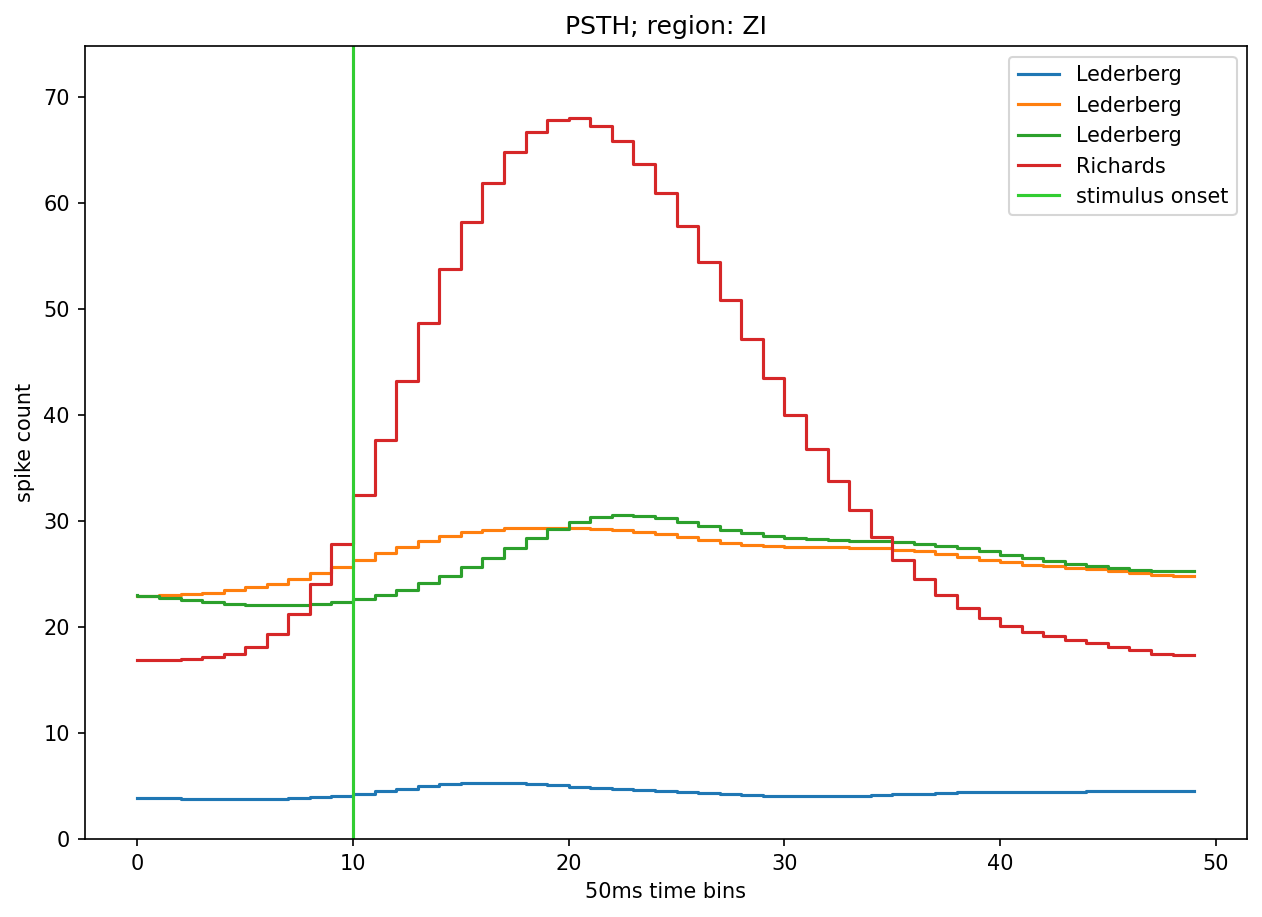

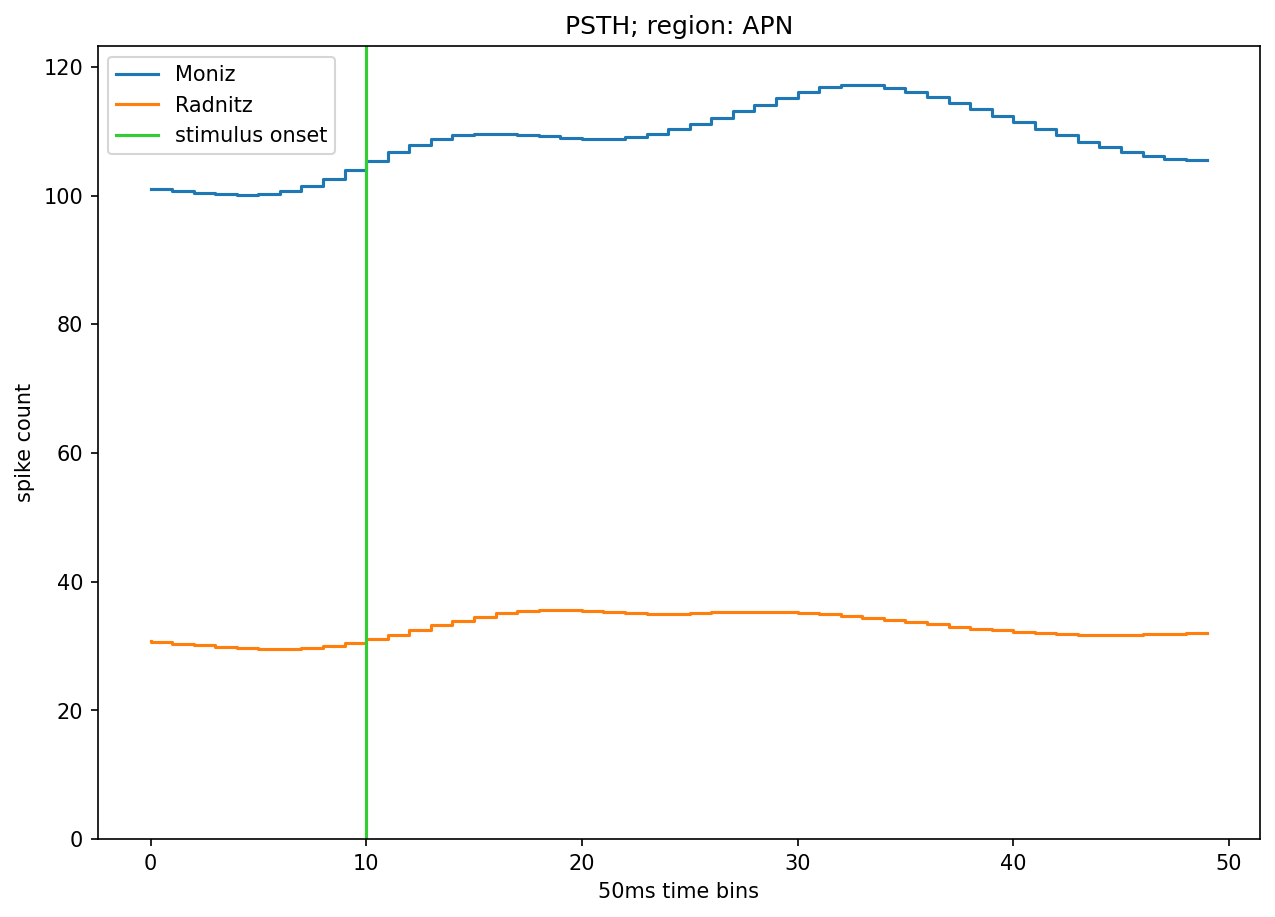

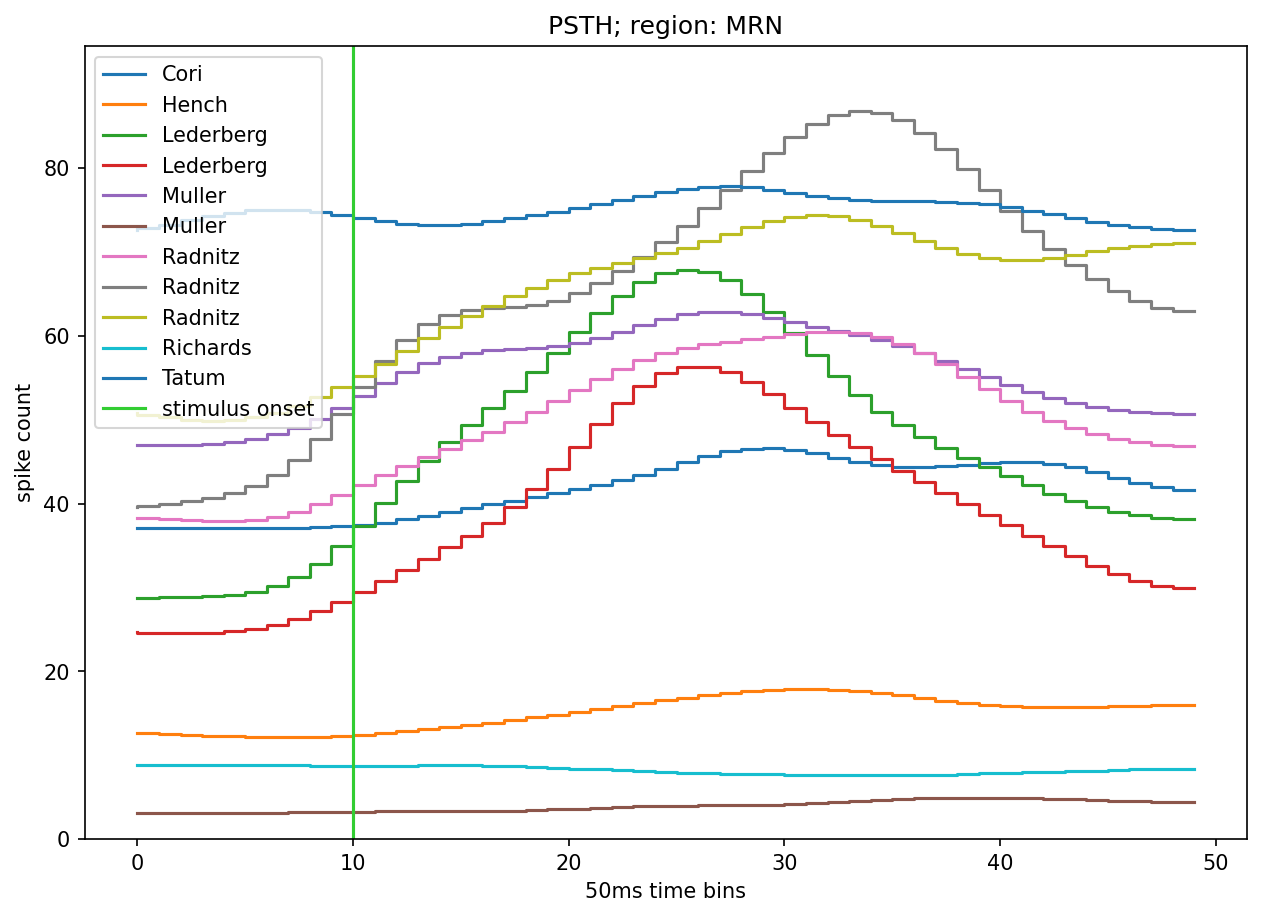

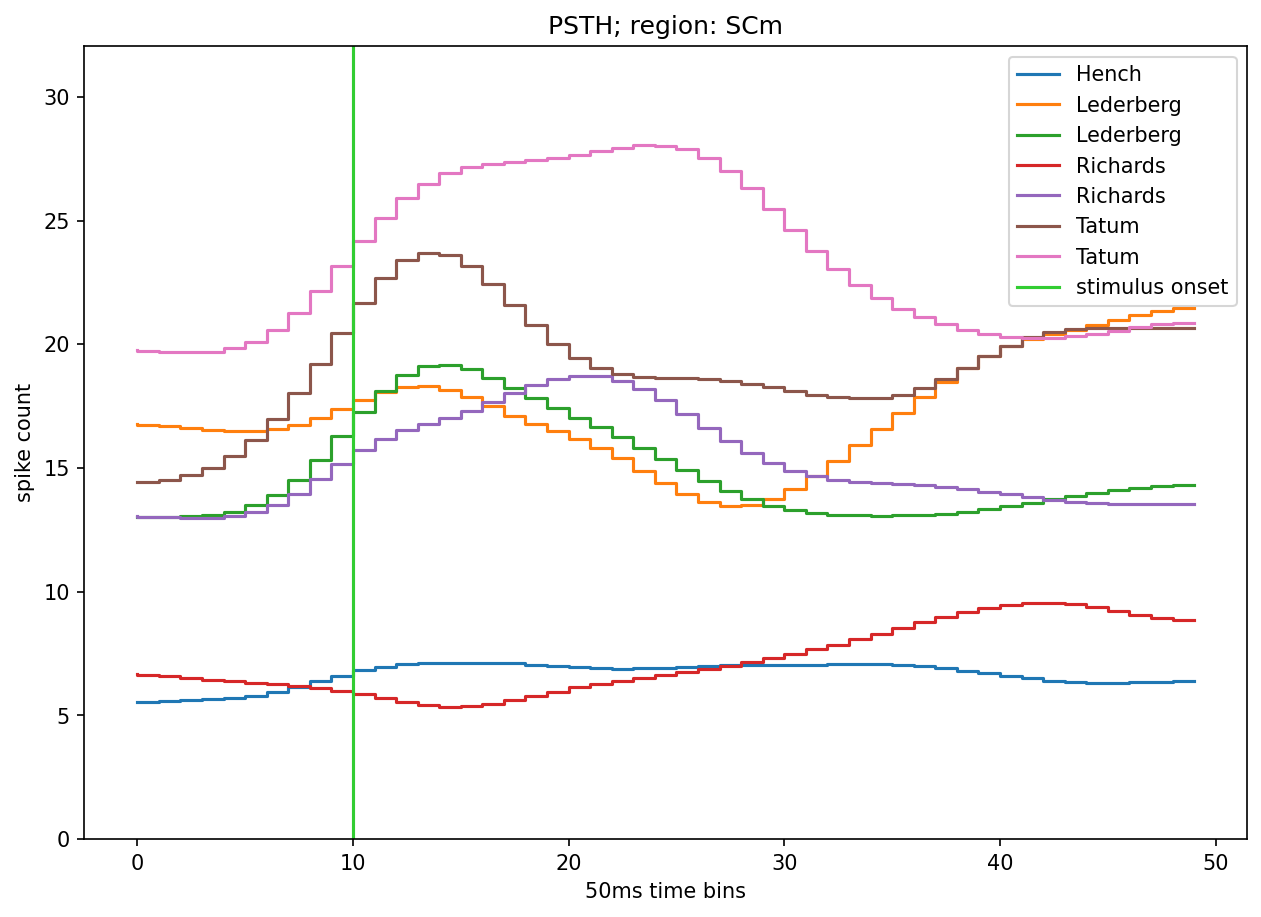

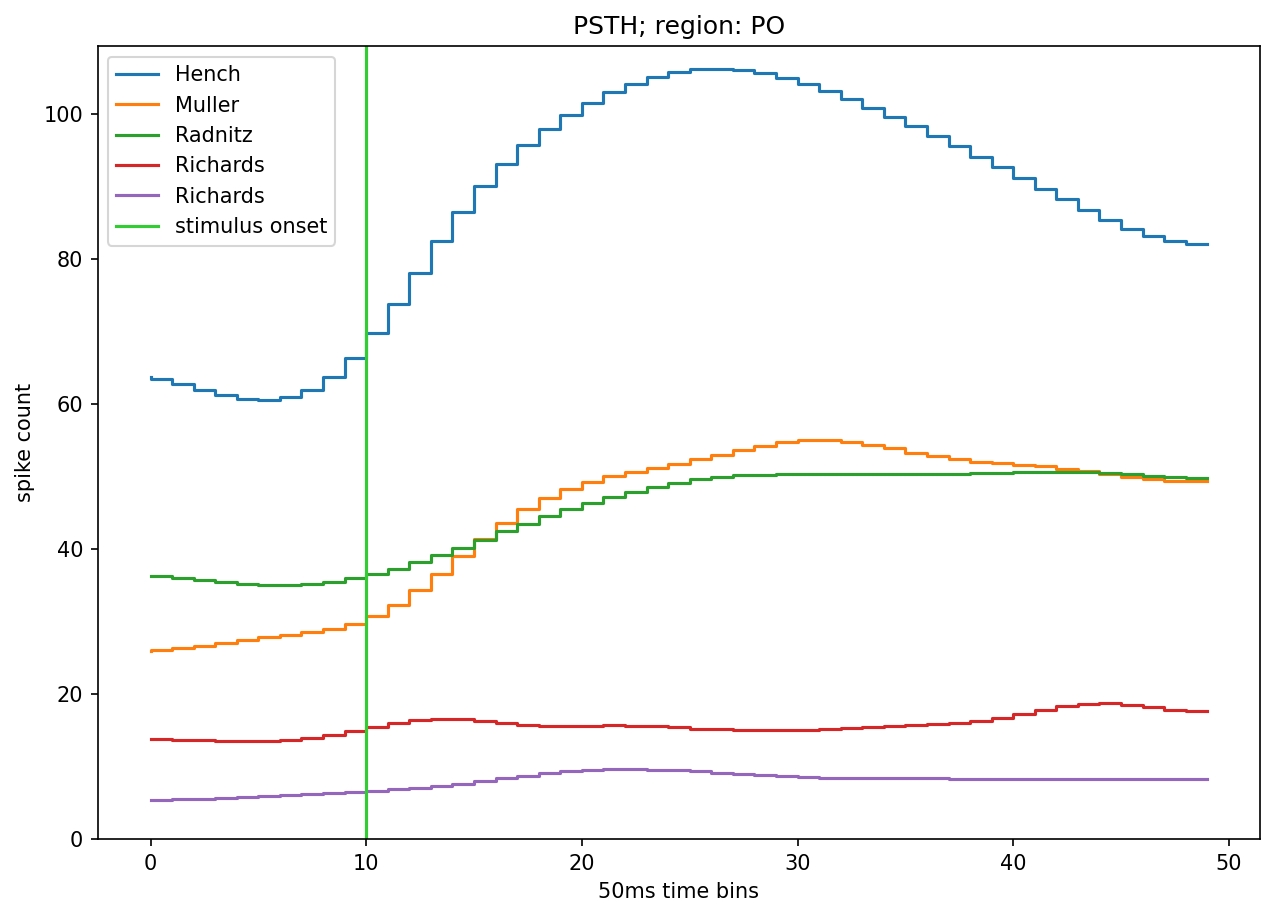

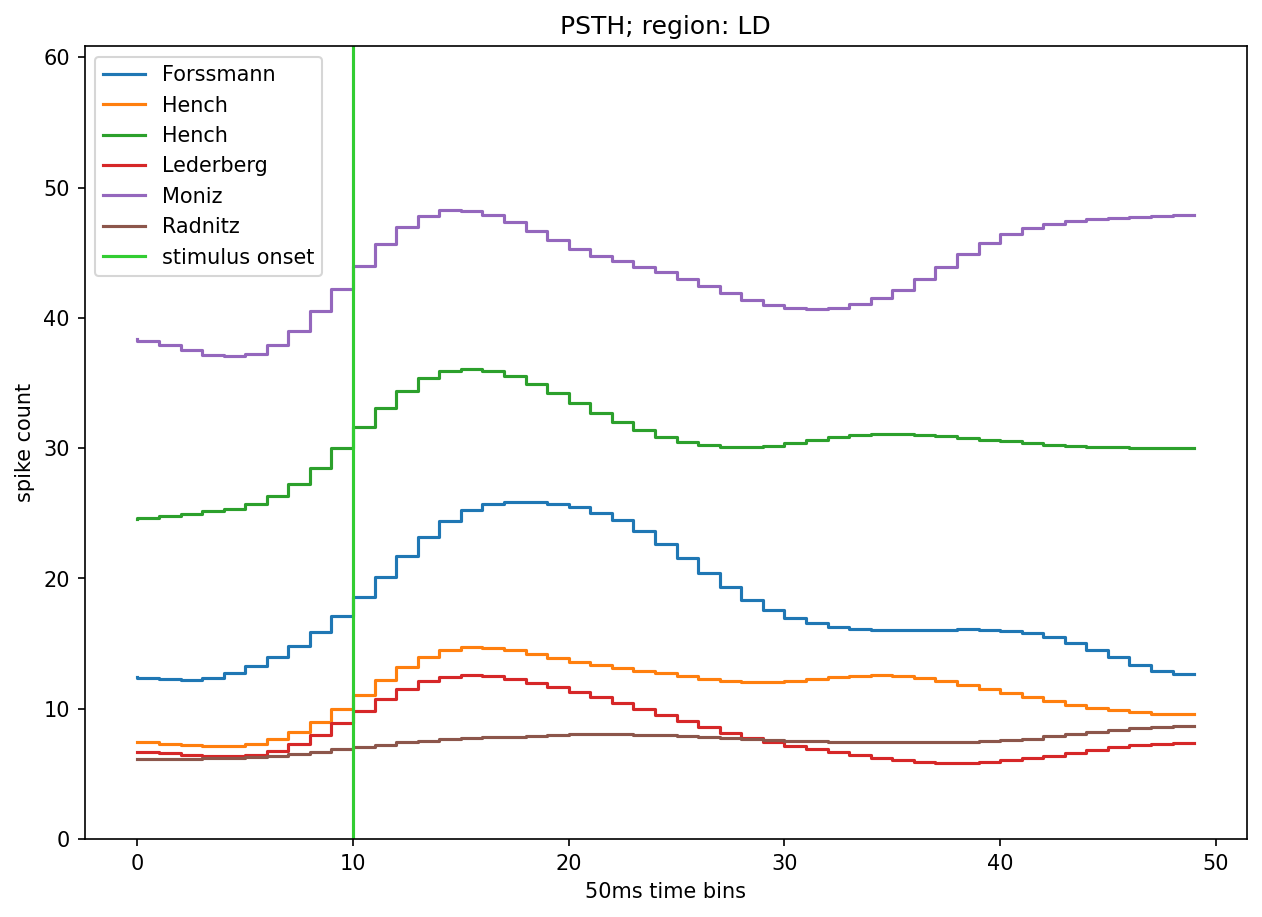

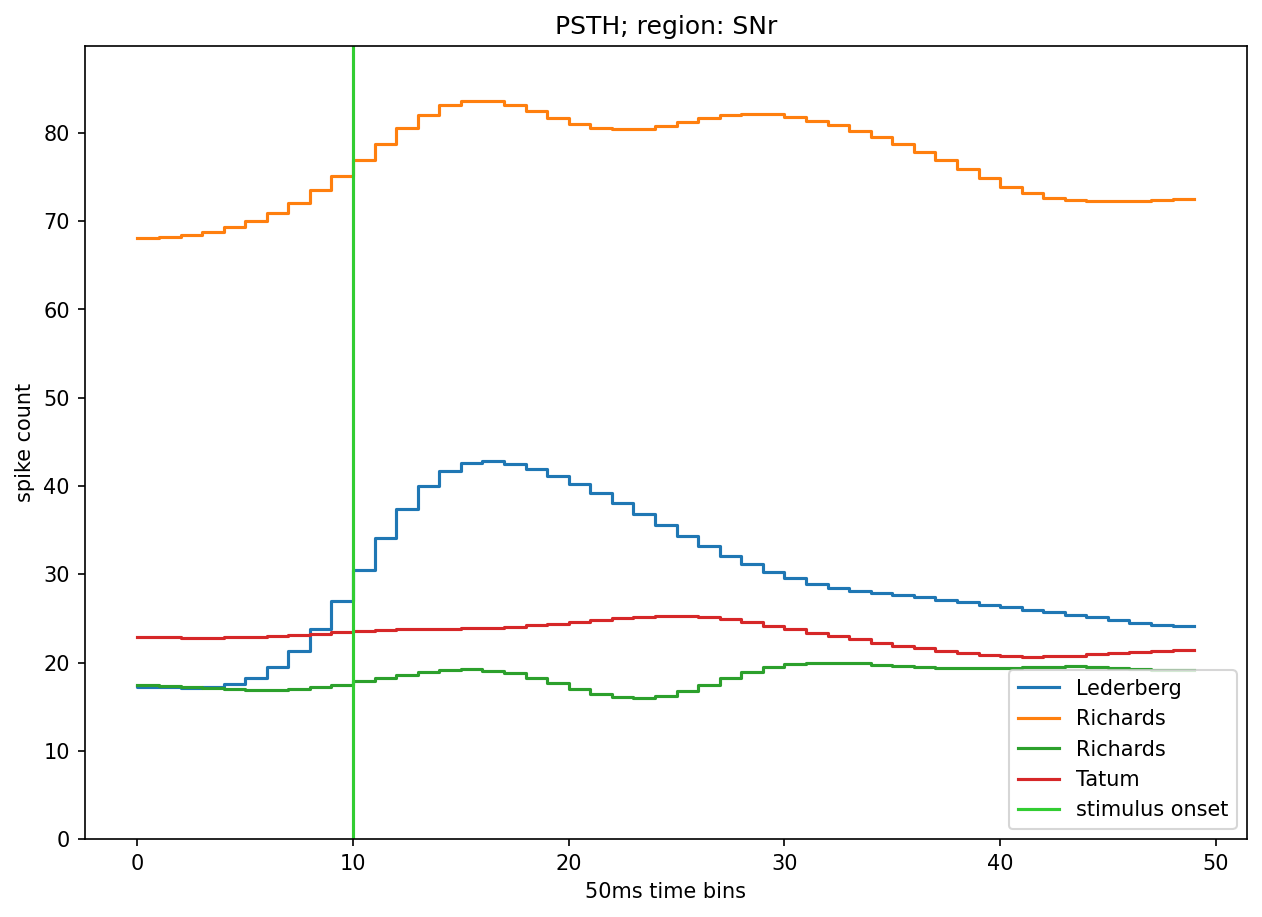

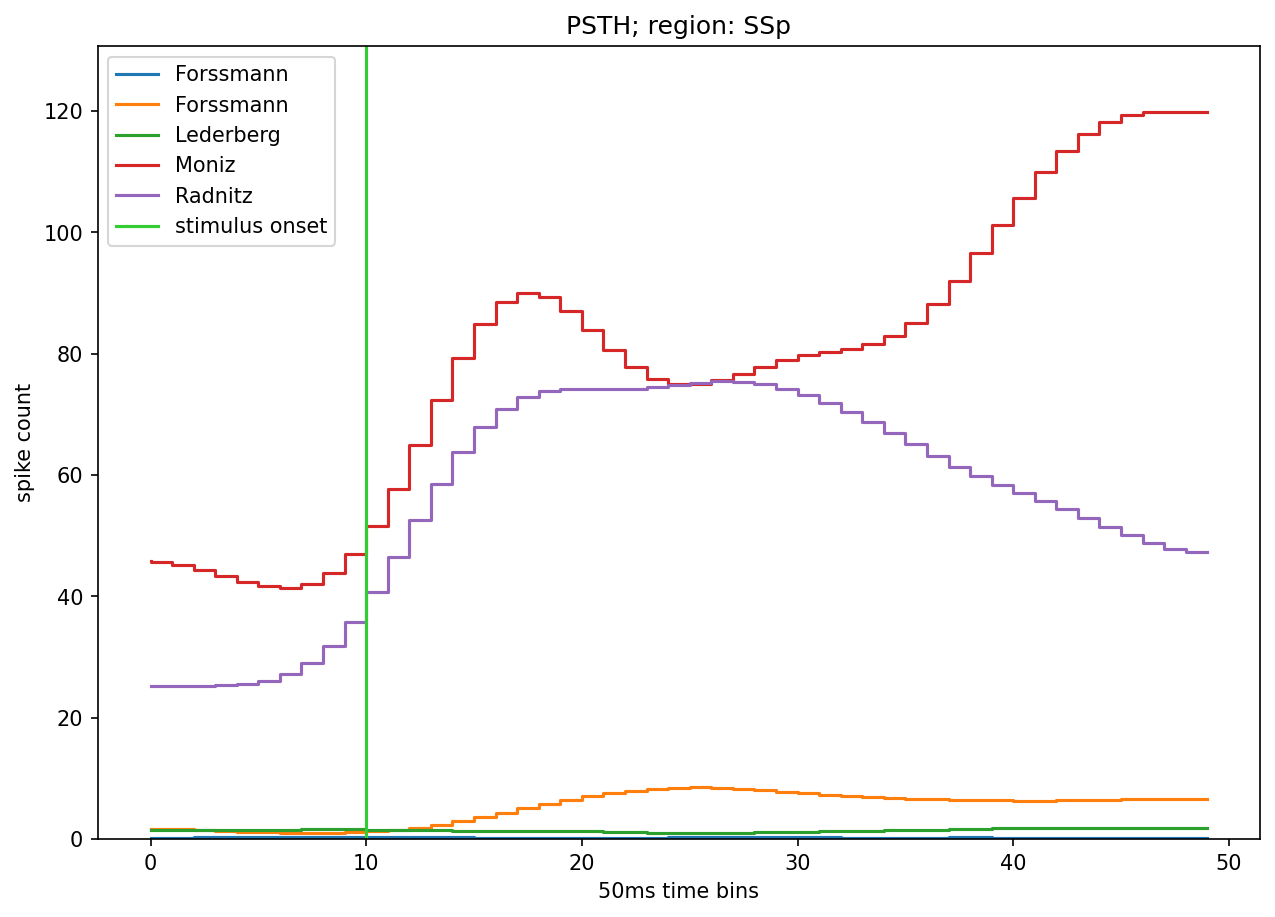

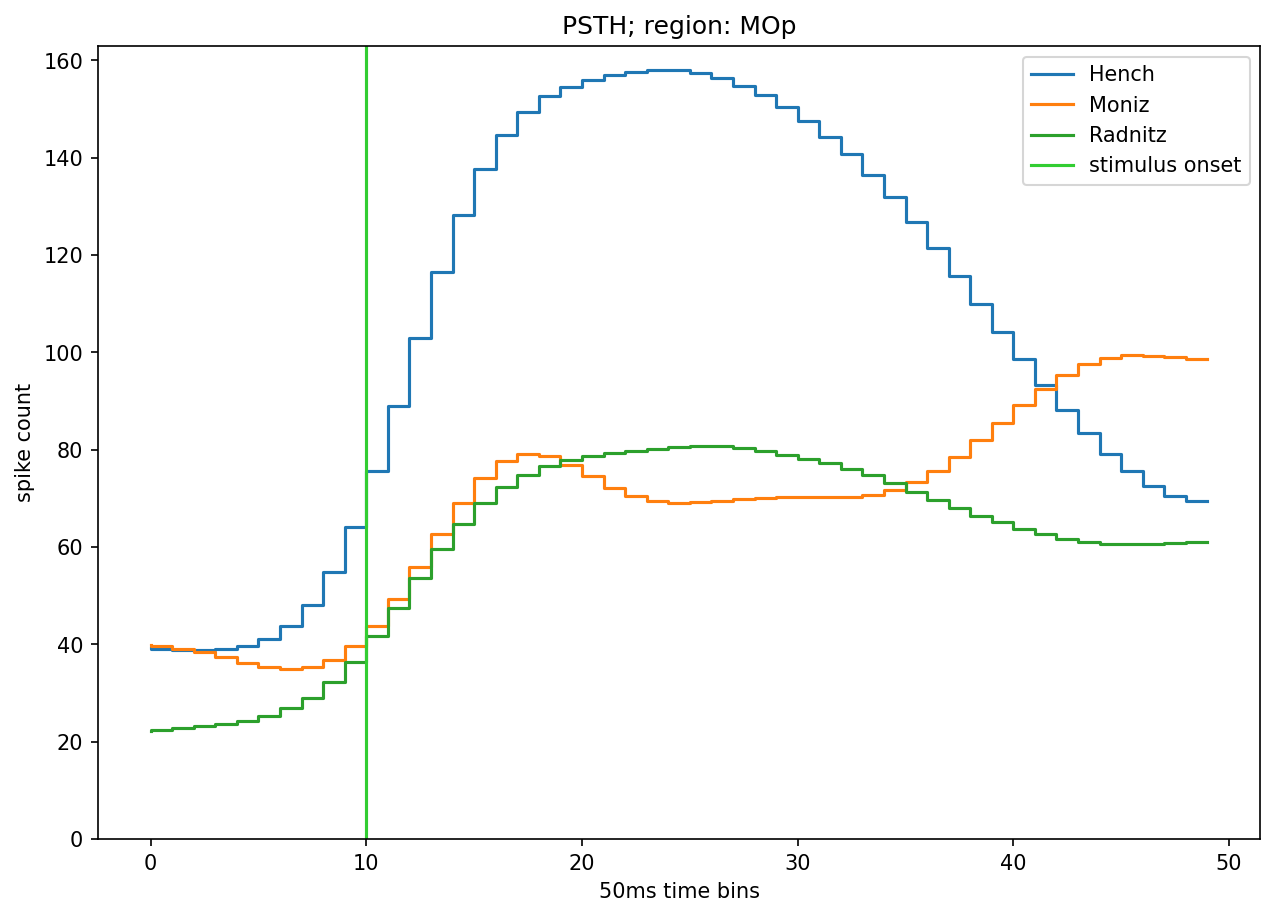

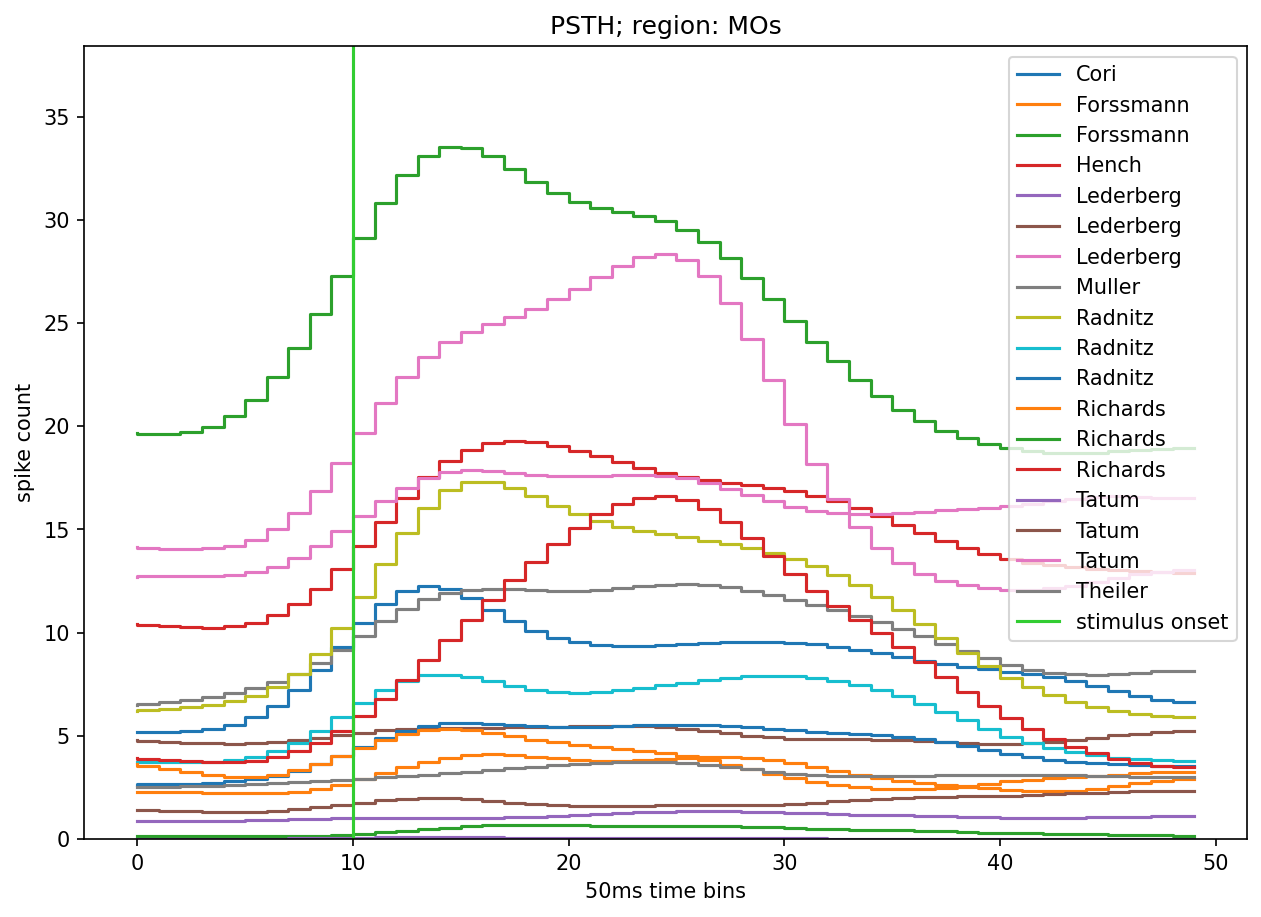

In [45]:
for idx, dat in enumerate(data_by_region):
    region = cr_top10[idx]
    # combine data for this region
    combined_spks = []
    for recording in dat:
        combined_spks.append([recording[0], recording[1]])
    combined_spks = np.asarray(combined_spks)
    # plot ptsh movements
    psth_combined_from_filtered1(combined_spks, region, timebin_size=5)

In [21]:
# combine data for one region

# for idx, dat in enumerate(data_by_region):
idx = 0
dat = data_by_region[idx]

region = cr_top10[idx]
# combine data for this region
combined_spks = []
combined_rsps = []
combined_rgs = []
for recording in dat:
    combined_spks.append(recording[1])
    combined_rsps.append(recording[7])
    combined_rgs.append(recording[2])
combined_spks = np.asarray(combined_spks)
combined_rsps = np.asarray(combined_rsps)
combined_rgs = np.asarray(combined_rgs)

# stack all trials togethers
combined_neurons = []
for dts in combined_spks:
    combined_neurons.append(np.vstack(dts))
combined_neurons = np.asarray(combined_neurons)

combined_responses = []
combined_regions = []
for i, rsp in enumerate(combined_rsps):
    neuron_count = combined_spks[i].shape[0]
    ext_rsps = np.tile(np.vstack(rsp), neuron_count)
    combined_responses.append(np.hstack(np.vstack(ext_rsps).T))
    
    trial_count = combined_spks[i].shape[1]
    ext_regions = np.tile(np.vstack(combined_rgs[i]), trial_count)
    combined_regions.append(np.hstack(np.vstack(ext_regions).T))
    
combined_responses = np.asarray(combined_responses)
combined_regions = np.asarray(combined_regions)

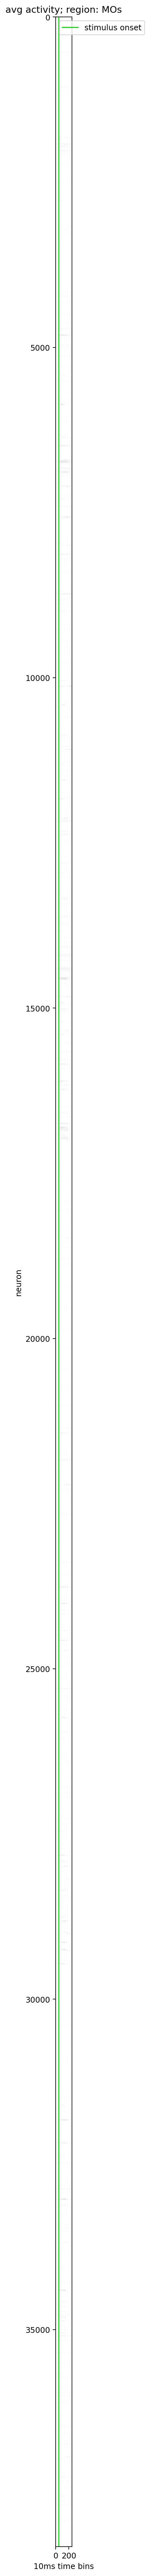

In [13]:
# plot ptsh movements
plot_spiking_activity_from_filtered(combined_neurons, region, sort=False)

In [15]:
print(combined_spks[0].shape)
print(combined_neurons[0].shape)
print(combined_responses[0].shape)
print(combined_regions[0].shape)

(113, 21, 250)
(2373, 250)
(2373,)
(2373,)


In [22]:
import umap

X = combined_neurons[0]
y = combined_responses[0]
target_names = [-1, 0, 1]

reducer = umap.UMAP()
reducer.fit(X)
embedding = reducer.transform(X)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
print(embedding.shape)

(345, 2)


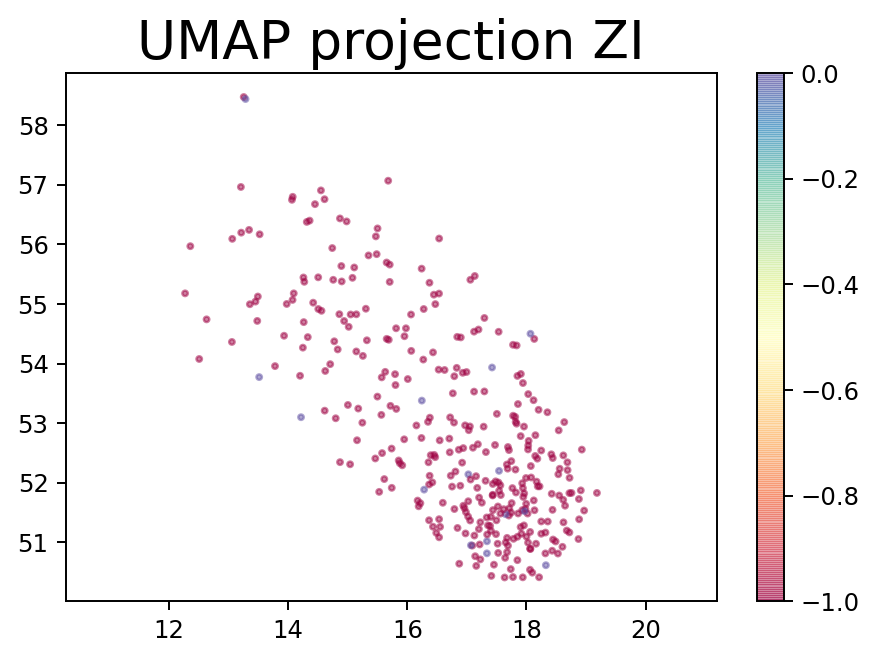

In [23]:
fig = plt.figure(dpi=175)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Spectral', s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection ZI', fontsize=22);

In [18]:
X = np.vstack(combined_neurons)
y = np.hstack(combined_responses)
# y = np.hstack(combined_regions)
target_names = [-1, 0, 1]

# convert string to int
# target_names = pd.get_dummies(y)
# target_names = target_names.values.argmax(1)


reducer = umap.UMAP(n_components=2)
reducer.fit(X)
embedding = reducer.transform(X)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
print(embedding.shape)

(38284, 2)


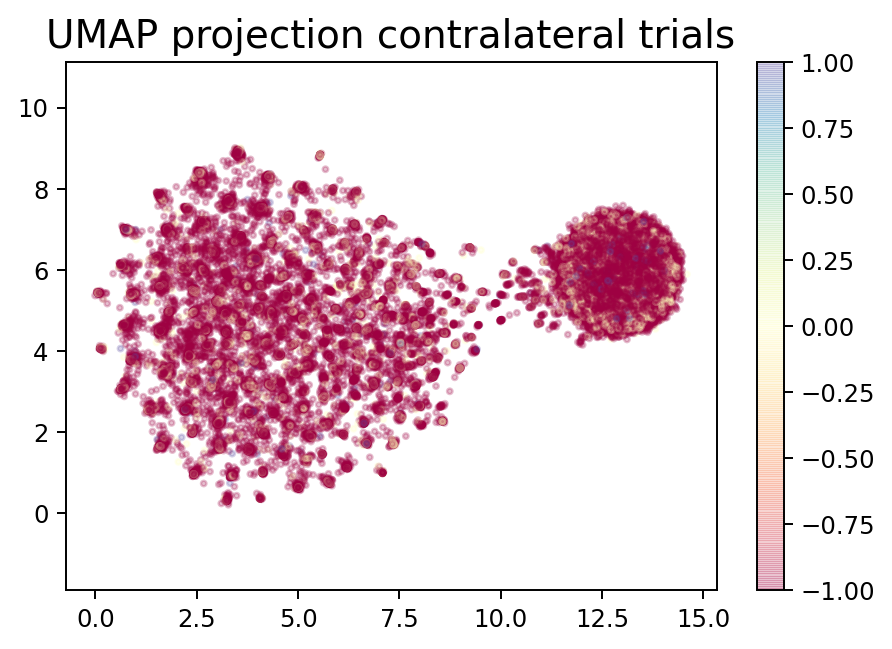

In [19]:
fig = plt.figure(dpi=175)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Spectral', s=5, alpha=0.25)
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.colorbar()
plt.title('UMAP projection contralateral trials', fontsize=16);

In [20]:
np.unique(combined_regions[-1])

array(['MOs'], dtype='<U3')

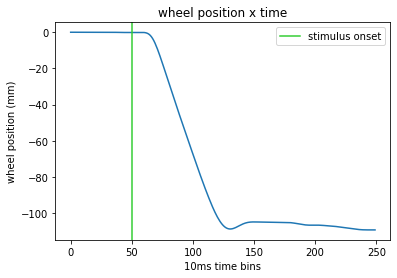

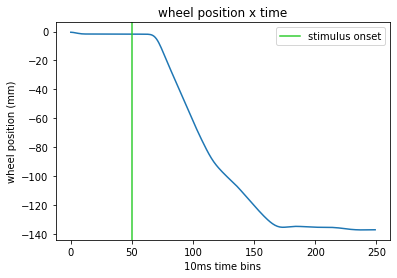

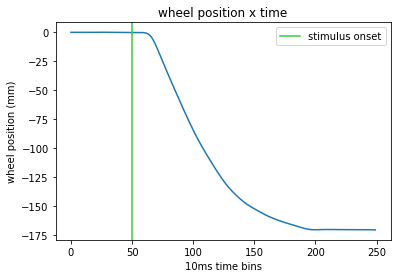

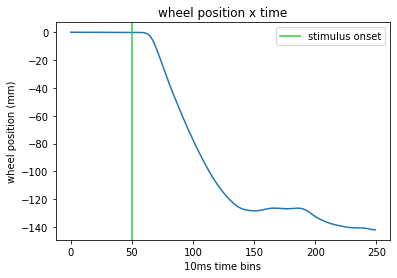

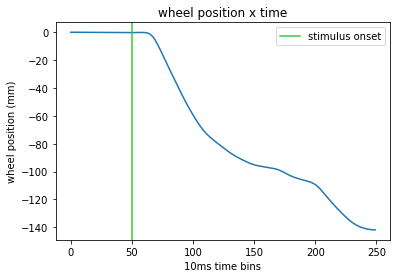

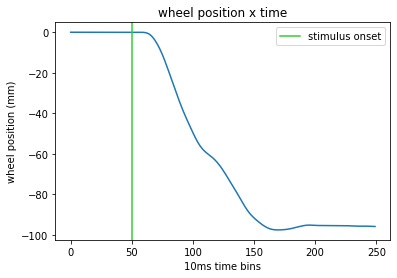

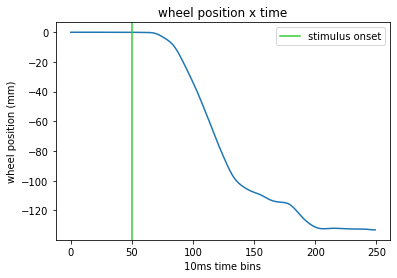

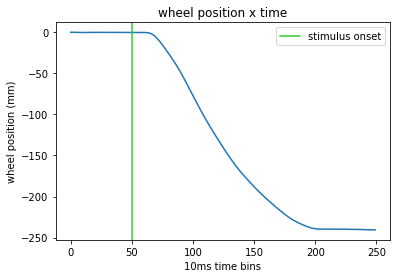

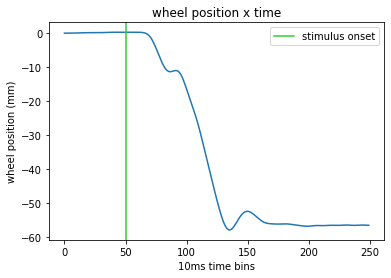

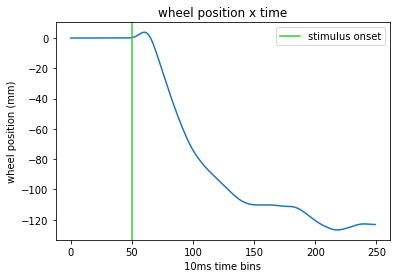

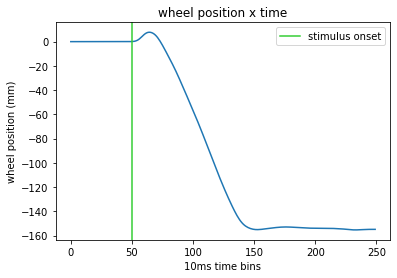

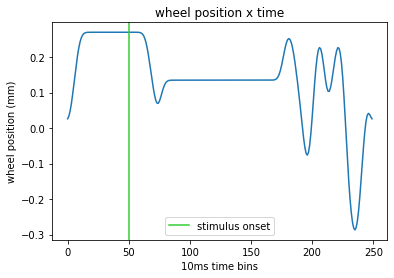

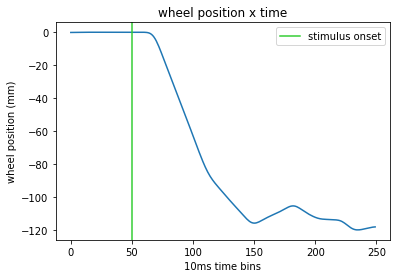

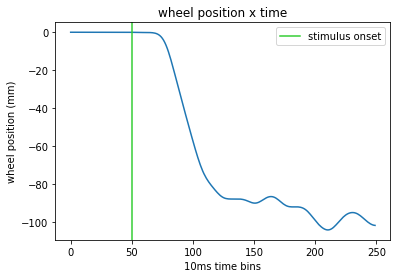

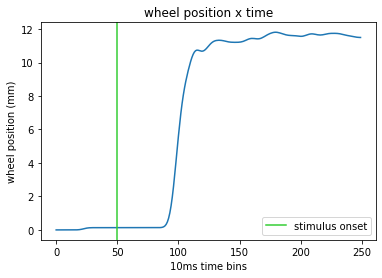

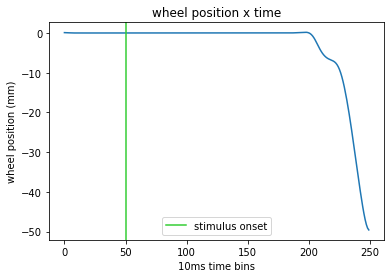

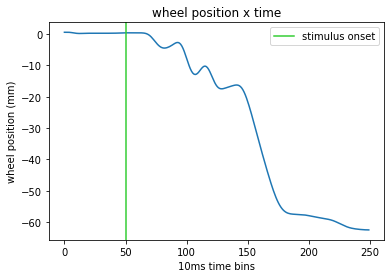

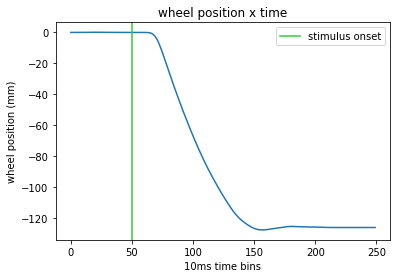

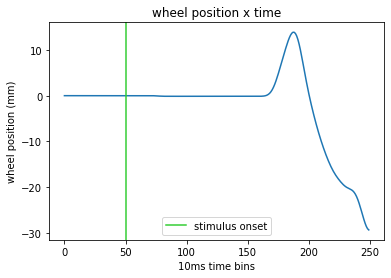

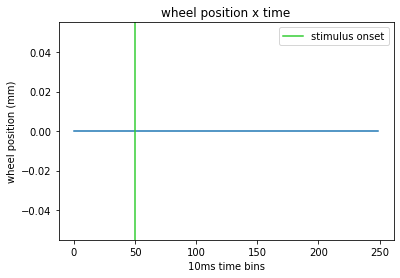

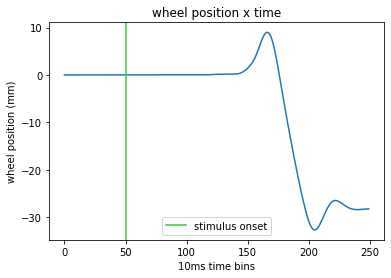

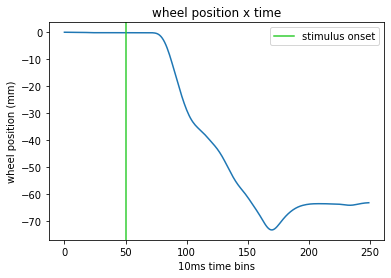

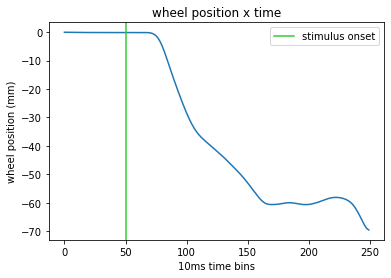

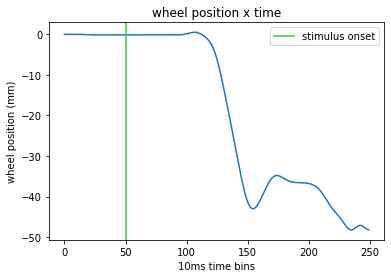

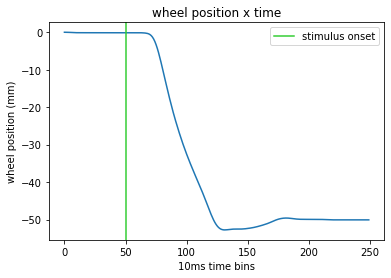

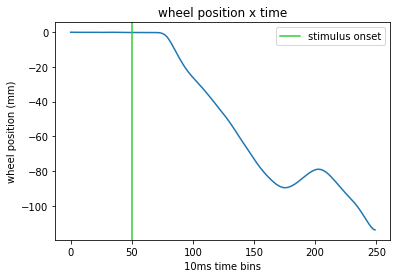

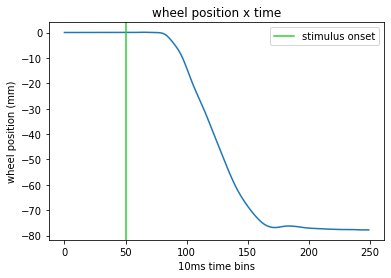

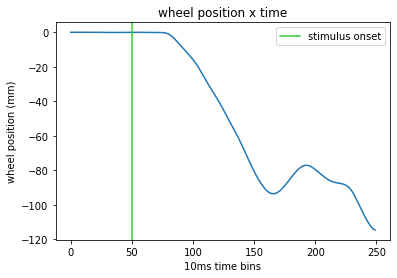

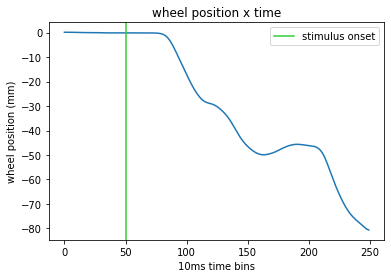

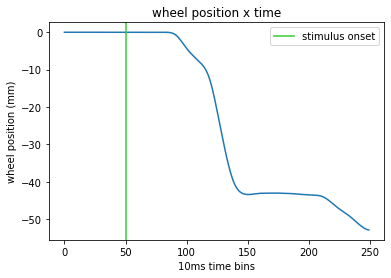

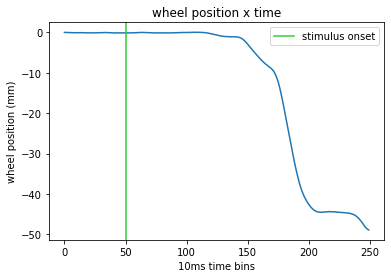

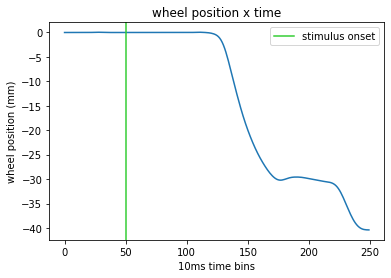

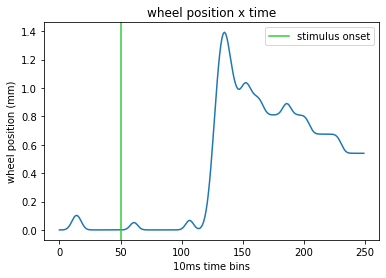

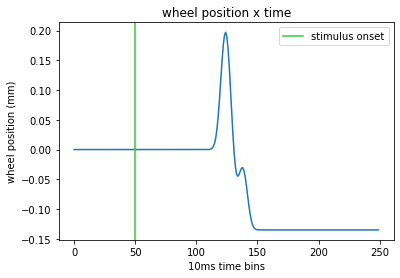

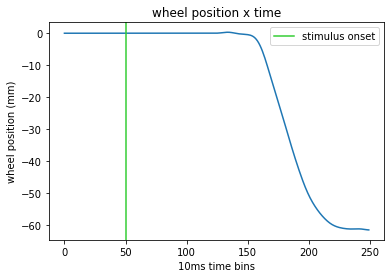

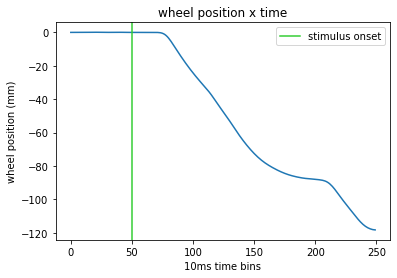

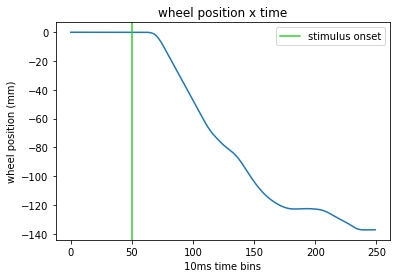

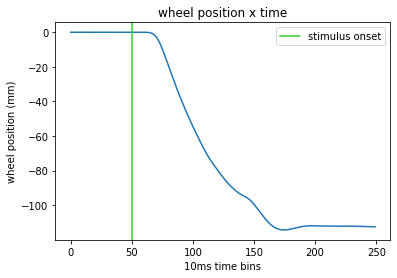

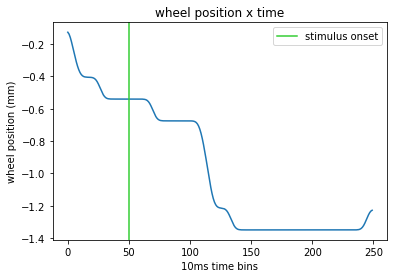

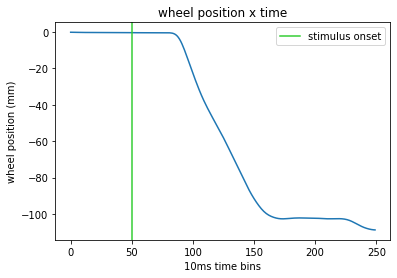

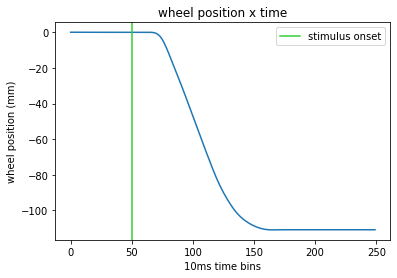

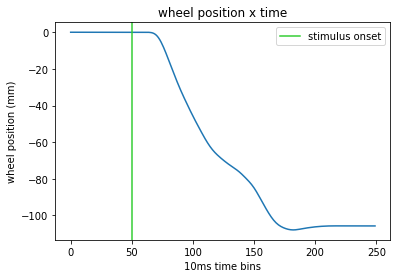

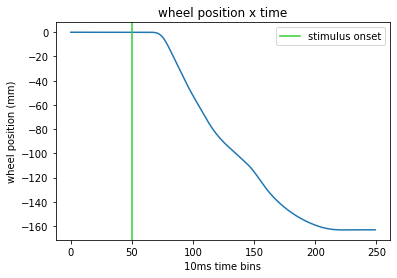

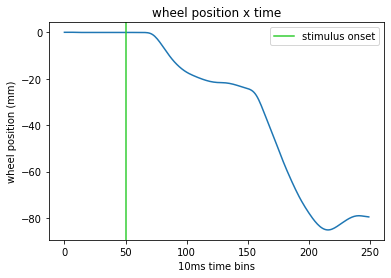

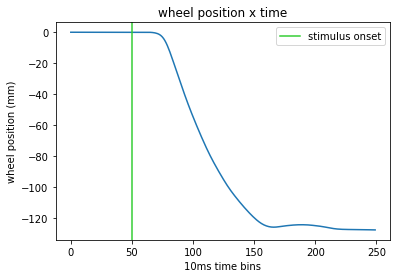

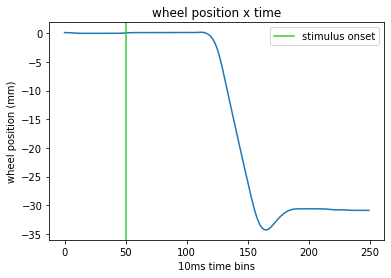

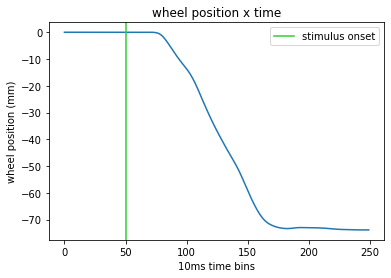

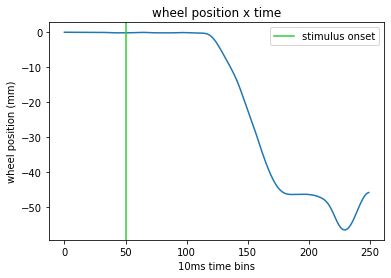

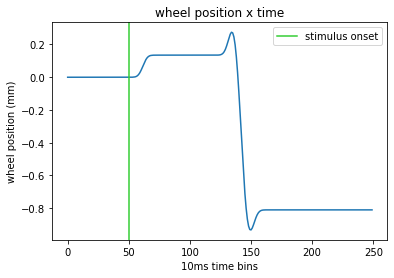

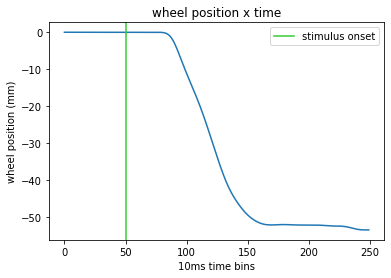

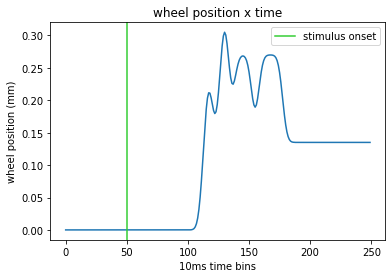

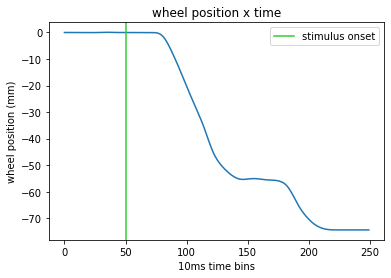

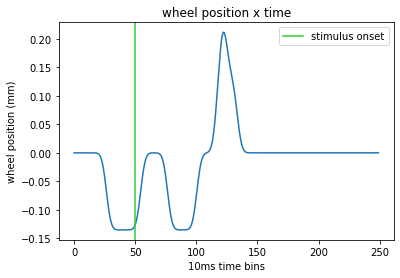

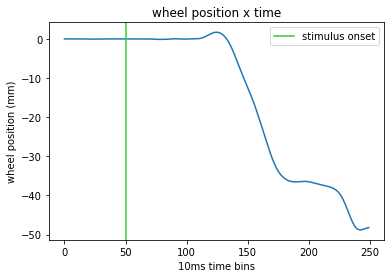

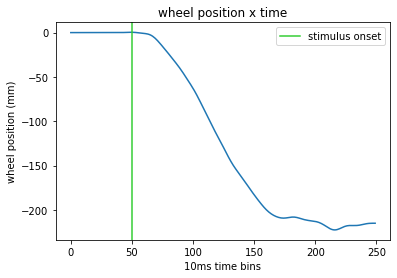

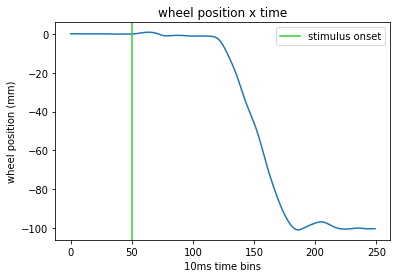

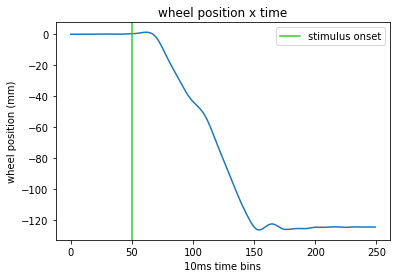

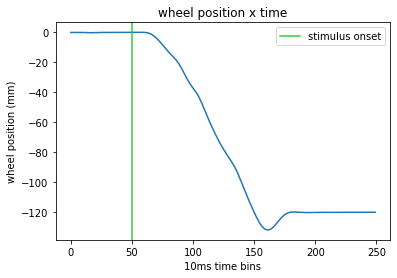

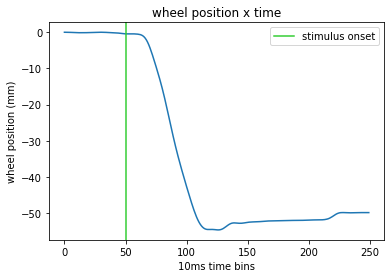

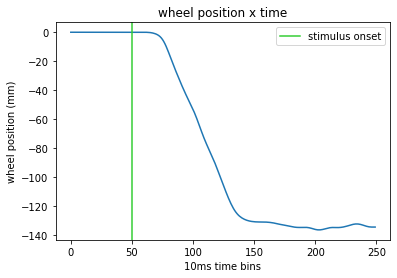

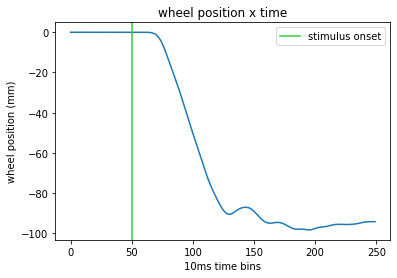

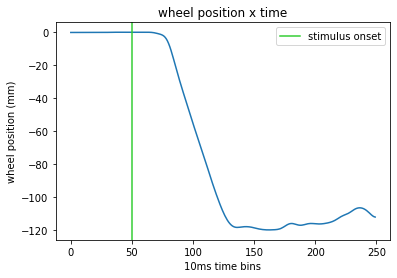

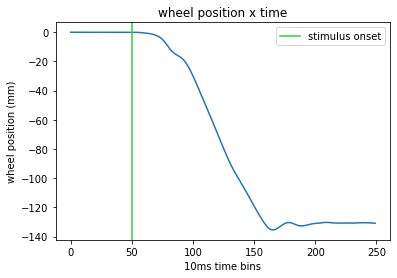

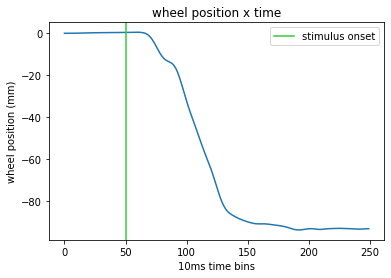

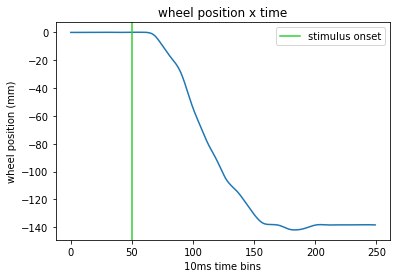

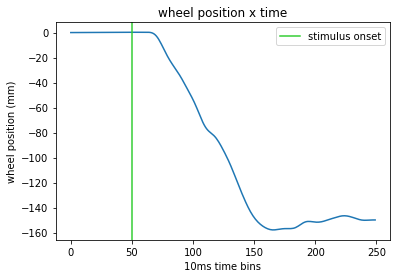

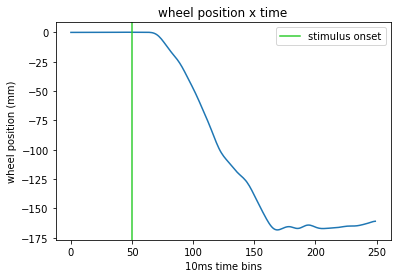

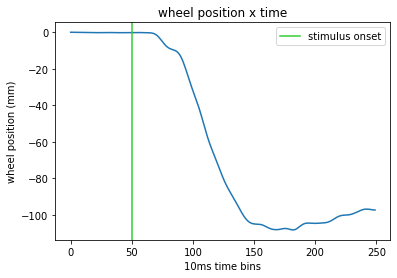

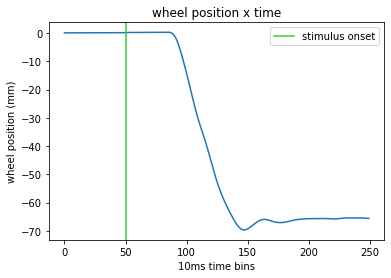

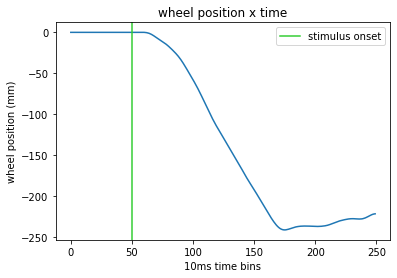

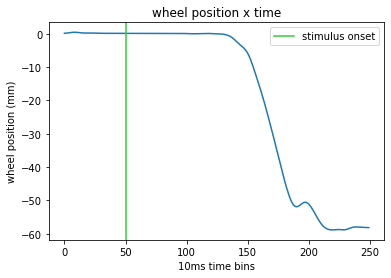

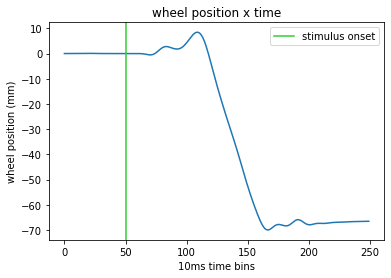

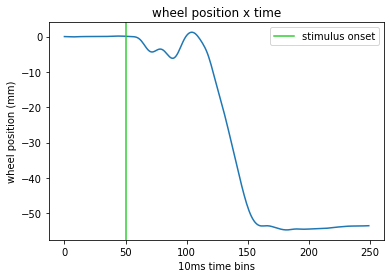

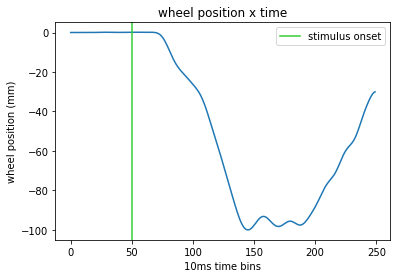

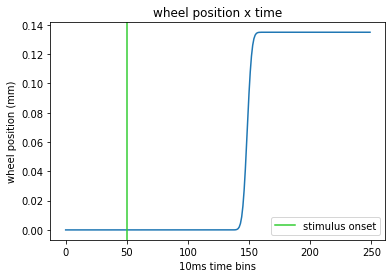

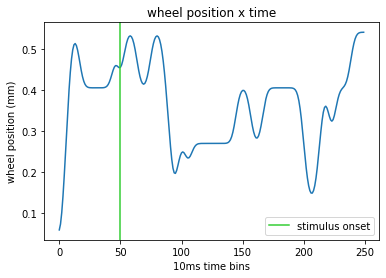

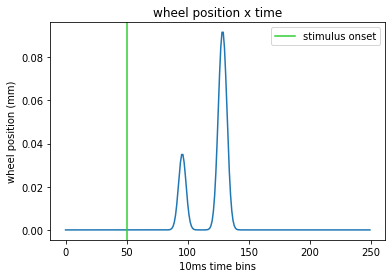

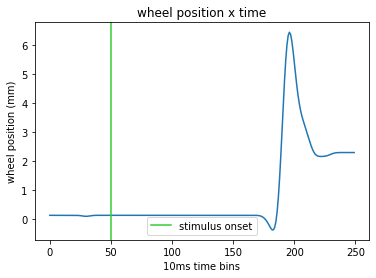

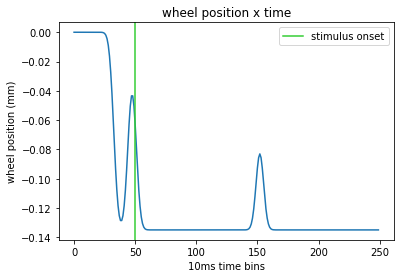

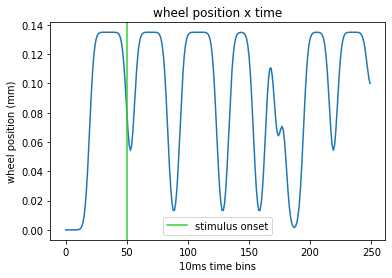

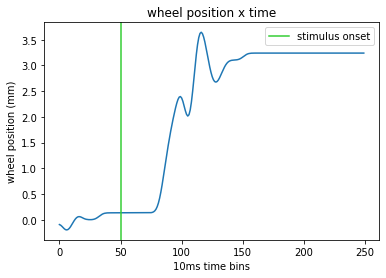

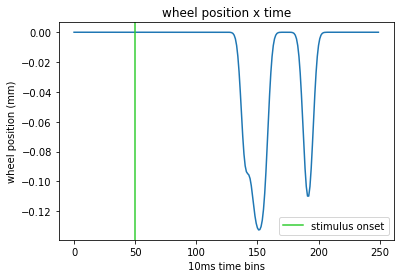

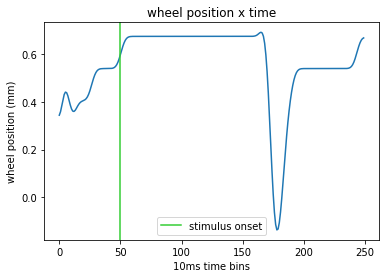

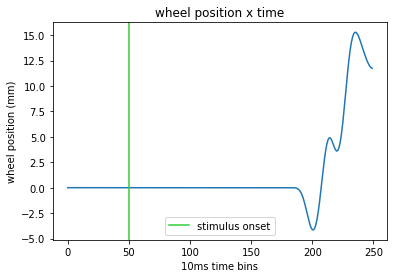

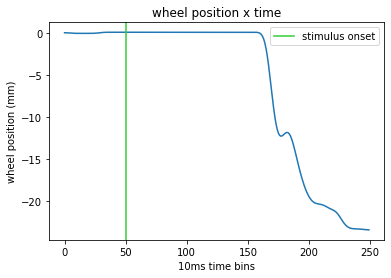

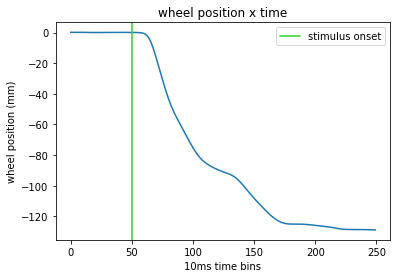

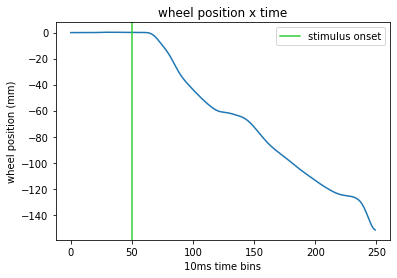

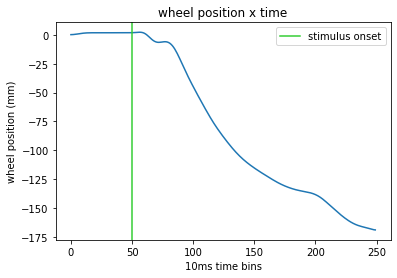

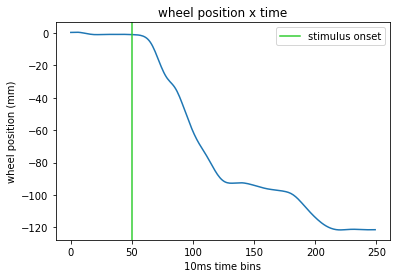

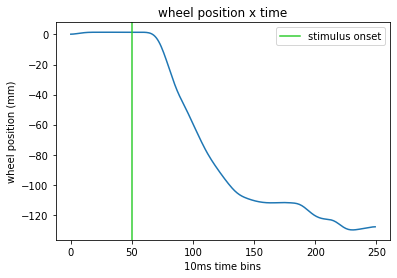

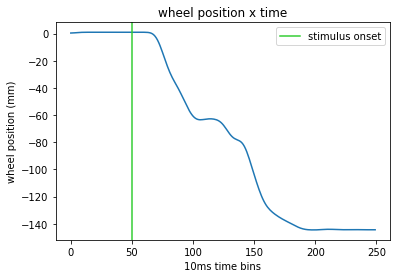

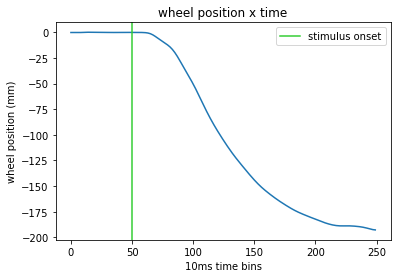

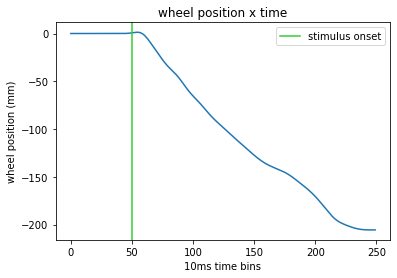

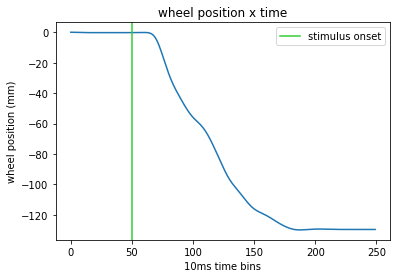

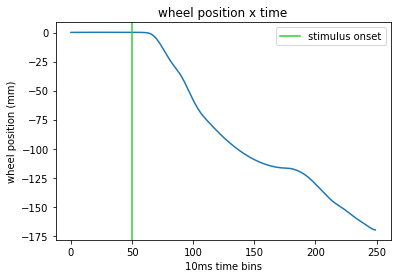

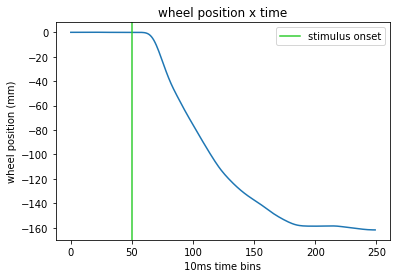

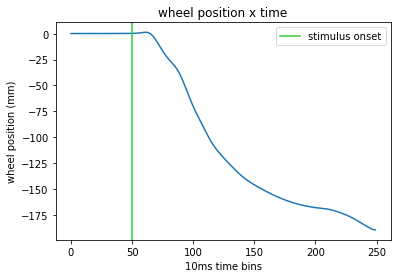

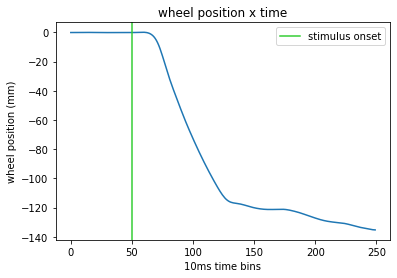

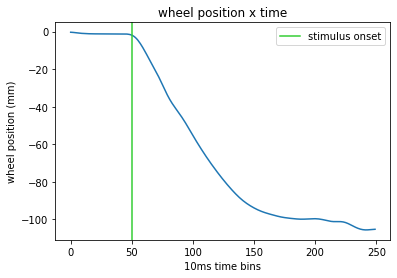

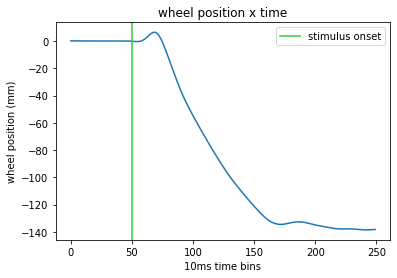

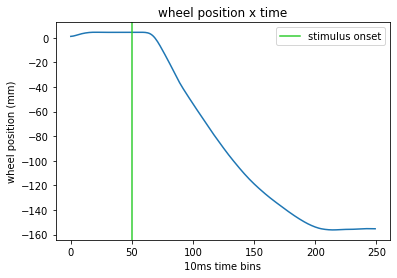

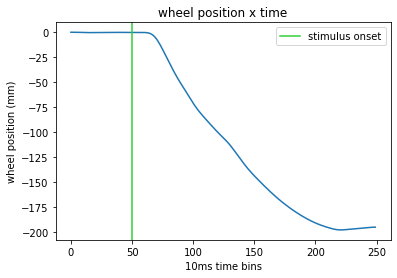

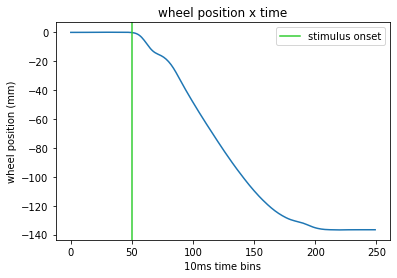

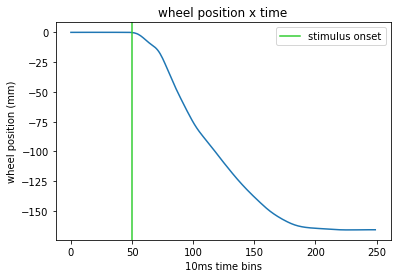

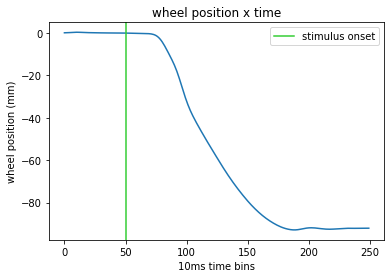

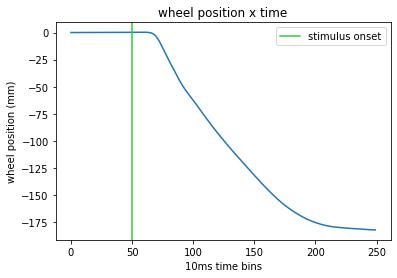

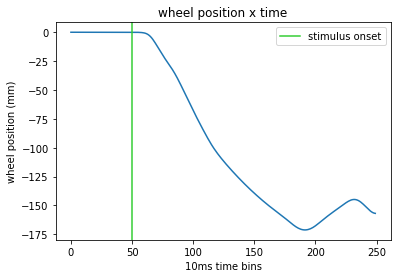

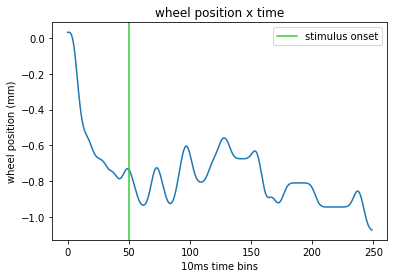

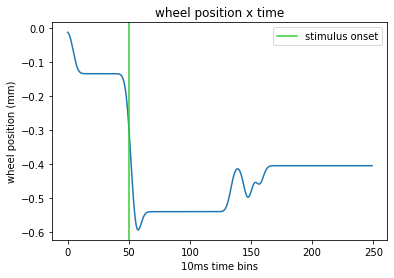

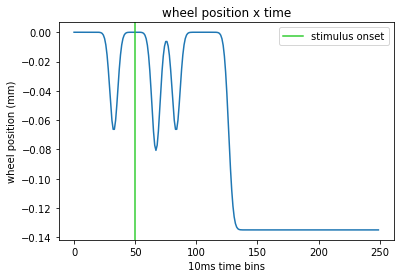

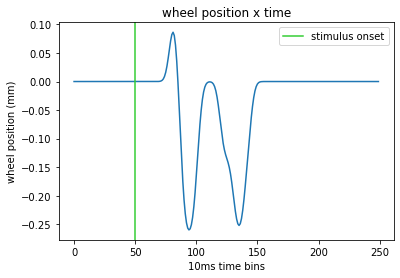

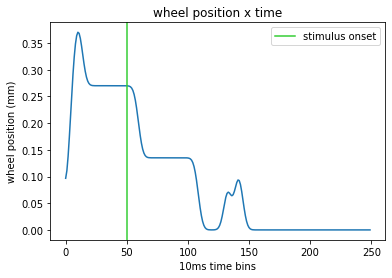

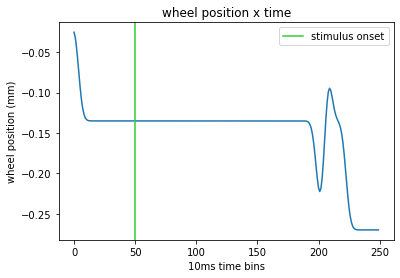

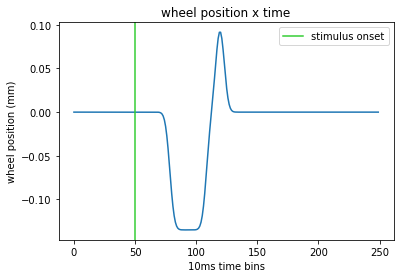

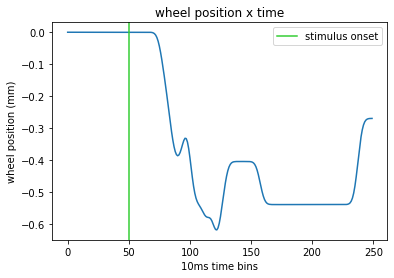

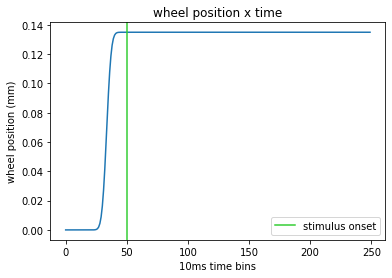

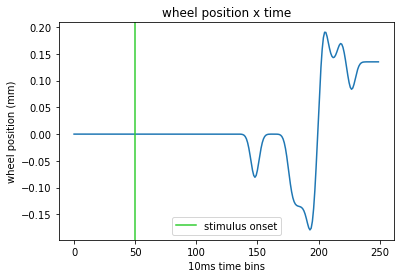

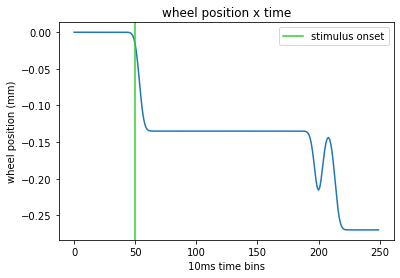

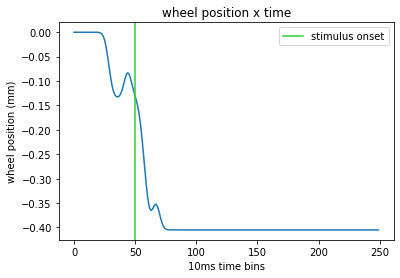

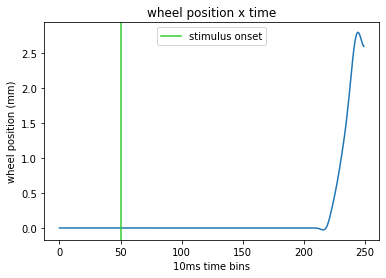

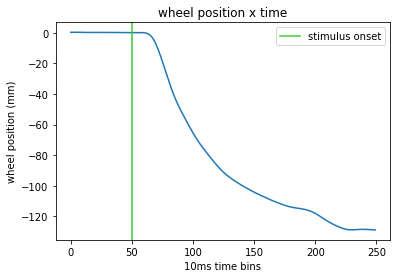

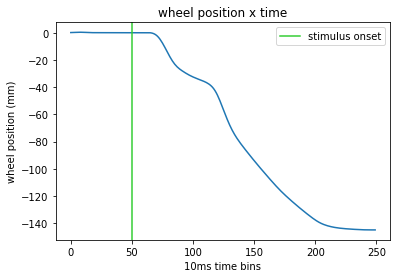

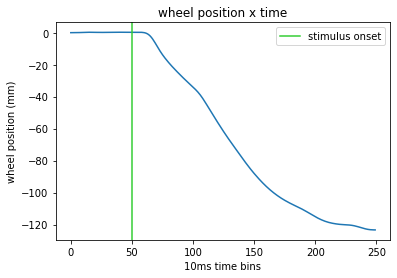

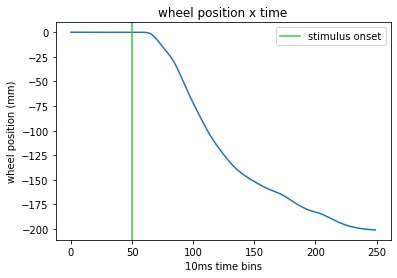

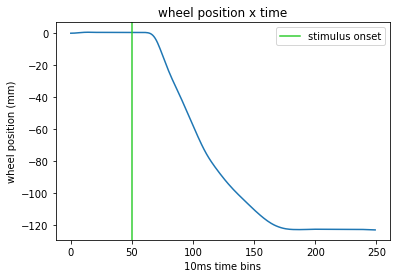

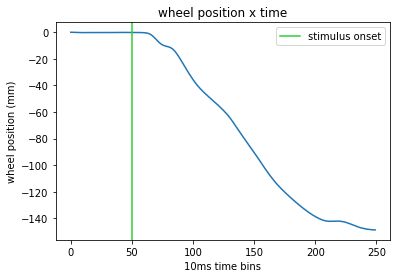

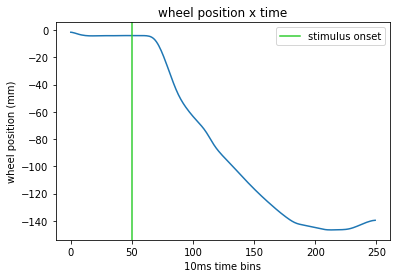

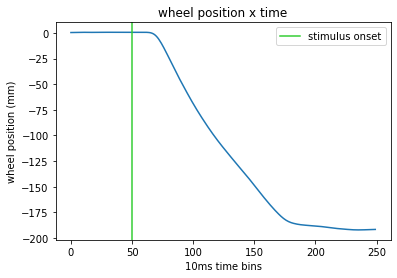

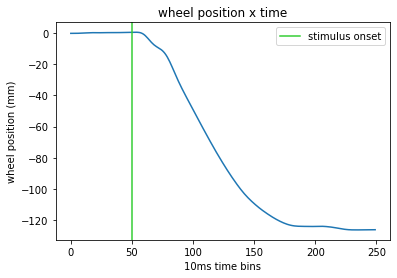

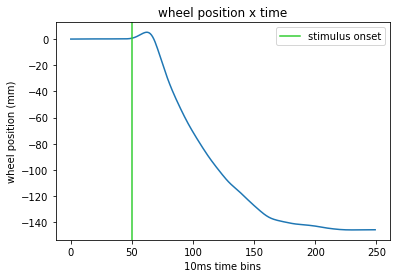

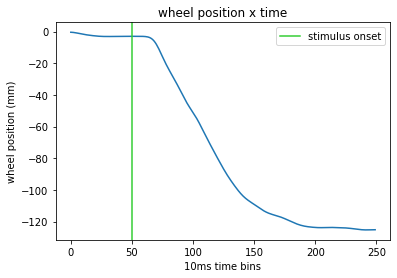

KeyboardInterrupt: 

In [14]:
# plot wheel movements
for recording in dat:
    for trial in recording[5]:
        plot_wheel_movement(trial)